# March Machine Learning Mania
In this notebook, we perform __EDA__ on the provided data via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview).

## Imports

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# global random seed
SEED = 9

## Load Data

In [2]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'



# historical seeds
seeds =  pd.concat([pd.read_csv(mroot + 'MNCAATourneySeeds.csv'), pd.read_csv(wroot + 'WNCAATourneySeeds.csv')], ignore_index=True)

# team names
teams = pd.concat([pd.read_csv(mroot + 'MTeams.csv'), pd.read_csv(wroot + 'WTeams.csv')], ignore_index=True)

# historical tourney results
results = pd.concat([pd.read_csv(mroot + 'MNCAATourneyCompactResults.csv'), pd.read_csv(wroot + 'WNCAATourneyCompactResults.csv')], ignore_index=True)

# tourney slots
mslots = pd.read_csv(mroot + 'MNCAATourneySlots.csv')
wslots = pd.read_csv(wroot + 'WNCAATourneySlots.csv')

# reg season results
regresults = pd.concat([pd.read_csv(mroot + 'MRegularSeasonCompactResults.csv'), pd.read_csv(wroot + 'WRegularSeasonCompactResults.csv')], ignore_index=True)



# create a map for team names
team_map = teams.set_index('TeamID')['TeamName']

## Feature Creation

We can simply generalize a lot from the seed of the team (and their opponent). The seed bakes in the performance of the team that year, as well as recent performance and key injuries. Even though the primary focus of seeding is on team performance, geography is also considered (to minimize travel for team/fans). This means that seeding may not be the perfect metric to use.

---
---

Features that may help predict a team's tourney performance (__Pre-bracket__):

__Features__ = features of that team's season, __Labels__ = Num wins in NCAA tourney, OR Binary W/L or score diff
- Wins
- Losses
- Win %
- Home/Road Win %
- Wins/Losses recently (say a month) before tourney
- Performance in conference tourney
- Performance in tourney prior year
- Avg/std pts
- Avg/std of opponent pts
- Avg/std pt differential
- Detailed stats
- Num championships in the past
- Play-in team?
- Longest win-streak in season

---

Features after 1st round is complete (__Intra-bracket__):

__Features__ = features of team's bracket stats so far
- Avg/std pts
- Avg/std of opponent pts
- Avg/std pt differential
- Detailed stats
- Coming off upset?

In [189]:
# compute score differential
regresults['ScoreDiff'] = regresults['WScore'] - regresults['LScore']

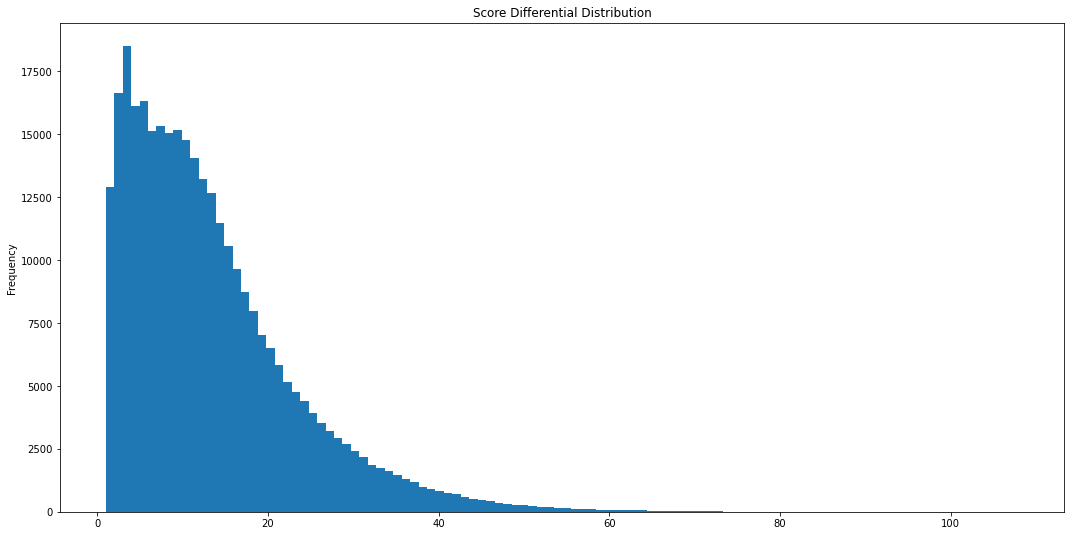

In [190]:
# look at dist of score differential in reg season games
regresults['ScoreDiff'].plot(kind='hist', bins=108, figsize=(18, 9), title='Score Differential Distribution');

In [191]:
# some groups we will be using
win_group = regresults.groupby(['Season', 'WTeamID'])
lose_group = regresults.groupby(['Season', 'LTeamID'])

In [192]:
# get wins and losses for every team in every season
num_wins = win_group.count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'num_wins', 'WTeamID': 'TeamID'})
num_losses = lose_group.count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'num_losses', 'LTeamID': 'TeamID'})

# merge wins and losses, fill nulls, cast to int, drop tables
win_loss = num_wins.merge(num_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
win_loss = win_loss.astype({'num_wins': int, 'num_losses': int})
del num_wins, num_losses

# add ratio
win_loss['win_ratio'] = win_loss['num_wins'] / (win_loss['num_wins'] + win_loss['num_losses'])

# check
print(win_loss.shape)
win_loss.head()

(22150, 5)


,Season,TeamID,num_wins,num_losses,win_ratio
0,1985,1102,5,19,0.208333
1,1985,1103,9,14,0.391304
2,1985,1104,21,9,0.700000
3,1985,1106,10,14,0.416667
4,1985,1108,19,6,0.760000


In [193]:
# 20 undefeated seasons
win_loss.loc[win_loss['num_losses'] == 0].shape

(20, 5)

In [194]:
# 48 winless seasons
win_loss.loc[win_loss['num_wins'] == 0].shape

(48, 5)

In [195]:
# get score diff deatures for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['mean', 'std', 'max']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'mean': 'avg_win_diff', 'std': 'std_win_diff', 'max': 'max_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['mean', 'std', 'max']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'mean': 'avg_loss_diff', 'std': 'std_loss_diff', 'max': 'max_loss_diff'})

# get pts for and against each team for wins and losses
pts_for_win = win_group['WScore'].agg(['mean', 'std']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'mean': 'avg_pts_for_win', 'std': 'std_pts_for_win'})
pts_against_win = win_group['LScore'].agg(['mean', 'std']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'mean': 'avg_pts_against_win', 'std': 'std_pts_against_win'})
pts_for_loss = lose_group['LScore'].agg(['mean', 'std']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'mean': 'avg_pts_for_loss', 'std': 'std_pts_for_loss'})
pts_against_loss = lose_group['WScore'].agg(['mean', 'std']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'mean': 'avg_pts_against_loss', 'std': 'std_pts_against_loss'})

# merge features, fill nulls, typecast, drop tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_for_win, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_against_win, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_for_loss, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_against_loss, on=['Season', 'TeamID'], how='outer').fillna(0)
pts = pts.astype({'max_win_diff': int, 'max_loss_diff': int})
del win_gaps, loss_gaps, pts_for_win, pts_against_win, pts_for_loss, pts_against_loss

# create 'merged' df by merging pts with win_loss
merged = pts.merge(win_loss, on=['Season', 'TeamID'], how='outer')
del win_loss, pts

# check
merged.head()

,Season,TeamID,avg_win_diff,std_win_diff,max_win_diff,avg_loss_diff,std_loss_diff,max_loss_diff,avg_pts_for_win,std_pts_for_win,avg_pts_against_win,std_pts_against_win,avg_pts_for_loss,std_pts_for_loss,avg_pts_against_loss,std_pts_against_loss,num_wins,num_losses,win_ratio
0,1985,1102,10.000000,11.135529,29,9.947368,9.565410,41,71.000000,14.966630,61.000000,12.020815,61.000000,7.423686,70.947368,8.771632,5,19,0.208333
1,1985,1103,7.555556,6.105553,16,9.857143,6.490907,22,70.222222,10.697871,62.666667,9.924717,55.142857,6.573339,65.000000,8.152395,9,14,0.391304
2,1985,1104,13.190476,8.127847,25,4.777778,3.419714,12,72.095238,13.604796,58.904762,11.414485,60.111111,10.982309,64.888889,13.336458,21,9,0.700000
3,1985,1106,9.500000,9.348202,28,13.285714,11.117751,35,75.100000,7.766738,65.600000,7.862711,69.142857,13.682426,82.428571,14.020393,10,14,0.416667
4,1985,1108,13.842105,10.920232,35,10.666667,4.676181,15,85.842105,14.911827,72.000000,8.906926,74.000000,4.774935,84.666667,4.366539,19,6,0.760000


In [196]:
# get H/A/N wins for each team
home_wins = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'home_wins', 'WTeamID': 'TeamID'})
away_wins = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'away_wins', 'WTeamID': 'TeamID'})
neutral_wins = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'neutral_wins', 'WTeamID': 'TeamID'})

# get H/A/N losses for each team
home_losses = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'home_losses', 'LTeamID': 'TeamID'})
away_losses = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'away_losses', 'LTeamID': 'TeamID'})
neutral_losses = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'neutral_losses', 'LTeamID': 'TeamID'})

# combine, fill nulls, typecast, drop tables
merged = merged.merge(home_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(home_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'home_wins': int, 'away_wins': int, 'neutral_wins': int, 'home_losses': int, 'away_losses': int, 'neutral_losses': int})
del home_wins, away_wins, neutral_wins, home_losses, away_losses, neutral_losses

# calculate win ratios for H/A/N games
merged['home_win_ratio'] = merged['home_wins'] / (merged['home_wins'] + merged['home_losses'])
merged['away_win_ratio'] = merged['away_wins'] / (merged['away_wins'] + merged['away_losses'])
merged['neutral_win_ratio'] = merged['neutral_wins'] / (merged['neutral_wins'] + merged['neutral_losses'])
merged = merged.fillna(0)

# check
merged.head()

,Season,TeamID,avg_win_diff,std_win_diff,max_win_diff,avg_loss_diff,std_loss_diff,max_loss_diff,avg_pts_for_win,std_pts_for_win,avg_pts_against_win,std_pts_against_win,avg_pts_for_loss,std_pts_for_loss,avg_pts_against_loss,std_pts_against_loss,num_wins,num_losses,win_ratio,home_wins,away_wins,neutral_wins,home_losses,away_losses,neutral_losses,home_win_ratio,away_win_ratio,neutral_win_ratio
0,1985,1102,10.000000,11.135529,29,9.947368,9.565410,41,71.000000,14.966630,61.000000,12.020815,61.000000,7.423686,70.947368,8.771632,5,19,0.208333,2,3,0,8,9,2,0.200000,0.250000,0.000000
1,1985,1103,7.555556,6.105553,16,9.857143,6.490907,22,70.222222,10.697871,62.666667,9.924717,55.142857,6.573339,65.000000,8.152395,9,14,0.391304,7,2,0,6,8,0,0.538462,0.200000,0.000000
2,1985,1104,13.190476,8.127847,25,4.777778,3.419714,12,72.095238,13.604796,58.904762,11.414485,60.111111,10.982309,64.888889,13.336458,21,9,0.700000,15,5,1,1,6,2,0.937500,0.454545,0.333333
3,1985,1106,9.500000,9.348202,28,13.285714,11.117751,35,75.100000,7.766738,65.600000,7.862711,69.142857,13.682426,82.428571,14.020393,10,14,0.416667,8,1,1,1,10,3,0.888889,0.090909,0.250000
4,1985,1108,13.842105,10.920232,35,10.666667,4.676181,15,85.842105,14.911827,72.000000,8.906926,74.000000,4.774935,84.666667,4.366539,19,6,0.760000,8,8,3,1,4,1,0.888889,0.666667,0.750000


In [197]:
# get all rows for each team where they won/lost by 3 points or less
close_wins = regresults.loc[regresults['ScoreDiff'] <= 3].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: '1_pos_wins', 'WTeamID': 'TeamID'})
close_losses = regresults.loc[regresults['ScoreDiff'] >= 3].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: '1_pos_losses', 'LTeamID': 'TeamID'})

# get num of games where NumOT > 0
ot_wins = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'ot_wins', 'WTeamID': 'TeamID'})
ot_losses = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'ot_losses', 'LTeamID': 'TeamID'})

# add missing indicator

# merge, fill nulls, typecast, drop tables
merged = merged.merge(close_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(close_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'1_pos_wins': int, '1_pos_losses': int, 'ot_wins': int, 'ot_losses': int})
del close_wins, close_losses, ot_wins, ot_losses

# calculate close and ot ratios
merged['1_pos_game_ratio'] = (merged['1_pos_wins'] + merged['1_pos_losses']) / (merged['num_wins'] + merged['num_losses'])
merged['1_pos_win_ratio'] = merged['1_pos_wins'] / (merged['1_pos_wins'] + merged['1_pos_losses'])
merged['ot_ratio'] = (merged['ot_wins'] + merged['ot_losses']) / (merged['num_wins'] + merged['num_losses'])
merged['ot_win_ratio'] = merged['ot_wins'] / (merged['ot_wins'] + merged['ot_losses'])

# fill nulls for teams that never played in close or ot games
merged = merged.fillna(0)

# check
merged.head()

,Season,TeamID,avg_win_diff,std_win_diff,max_win_diff,avg_loss_diff,std_loss_diff,max_loss_diff,avg_pts_for_win,std_pts_for_win,avg_pts_against_win,std_pts_against_win,avg_pts_for_loss,std_pts_for_loss,avg_pts_against_loss,std_pts_against_loss,num_wins,num_losses,win_ratio,home_wins,away_wins,neutral_wins,home_losses,away_losses,neutral_losses,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_wins,1_pos_losses,ot_wins,ot_losses,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio
0,1985,1102,10.000000,11.135529,29,9.947368,9.565410,41,71.000000,14.966630,61.000000,12.020815,61.000000,7.423686,70.947368,8.771632,5,19,0.208333,2,3,0,8,9,2,0.200000,0.250000,0.000000,2,19,0,0,0.875000,0.095238,0.000000,0.0
1,1985,1103,7.555556,6.105553,16,9.857143,6.490907,22,70.222222,10.697871,62.666667,9.924717,55.142857,6.573339,65.000000,8.152395,9,14,0.391304,7,2,0,6,8,0,0.538462,0.200000,0.000000,4,14,0,0,0.782609,0.222222,0.000000,0.0
2,1985,1104,13.190476,8.127847,25,4.777778,3.419714,12,72.095238,13.604796,58.904762,11.414485,60.111111,10.982309,64.888889,13.336458,21,9,0.700000,15,5,1,1,6,2,0.937500,0.454545,0.333333,4,9,0,1,0.433333,0.307692,0.033333,0.0
3,1985,1106,9.500000,9.348202,28,13.285714,11.117751,35,75.100000,7.766738,65.600000,7.862711,69.142857,13.682426,82.428571,14.020393,10,14,0.416667,8,1,1,1,10,3,0.888889,0.090909,0.250000,4,14,0,0,0.750000,0.222222,0.000000,0.0
4,1985,1108,13.842105,10.920232,35,10.666667,4.676181,15,85.842105,14.911827,72.000000,8.906926,74.000000,4.774935,84.666667,4.366539,19,6,0.760000,8,8,3,1,4,1,0.888889,0.666667,0.750000,5,6,0,0,0.440000,0.454545,0.000000,0.0


In [198]:
# num of final reg season games to aggregate
RECENT_GAMES = 6

# get last RECENT_GAMES wins and last RECENT_GAMES losses of each team (to assess recent form going into tourney)
recent_wins = win_group.tail(RECENT_GAMES).reset_index(drop=True)
recent_losses = lose_group.tail(RECENT_GAMES).reset_index(drop=True)

# add TeamID col to identify thw rows pertaining to each team
recent_wins['TeamID'] = recent_wins['WTeamID']
recent_losses['TeamID'] = recent_losses['LTeamID']

# get last RECENT_GAMES games
combined = pd.concat([recent_wins, recent_losses], ignore_index=True).sort_values(by=['Season', 'TeamID', 'DayNum']).reset_index(drop=True)
last_recent_games = combined.groupby(['Season', 'TeamID']).tail(RECENT_GAMES).reset_index(drop=True)
del combined, recent_wins, recent_losses

# check
last_recent_games.head(6)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreDiff,TeamID
0,1985,115,1102,52,1461,49,A,0,3,1102
1,1985,117,1102,58,1218,54,H,0,4,1102
2,1985,120,1161,65,1102,63,A,0,2,1102
3,1985,122,1428,60,1102,59,A,0,1,1102
4,1985,126,1102,82,1140,79,A,0,3,1102
5,1985,127,1428,66,1102,64,H,0,2,1102


In [199]:
# look at teams who don't have a final RECEENT_GAMES games
last_recent_games.groupby(['Season', 'TeamID']).size().reset_index().rename(columns={0: 'num_games'}).sort_values(by='num_games', ascending=True).head(10)

,Season,TeamID,num_games
19987,2021,3469,2
19887,2021,3363,4
19714,2021,3181,4
19410,2021,1224,4
19684,2021,3145,5
19960,2021,3438,5
0,1985,1102,6
14765,2014,3126,6
14764,2014,3125,6
14763,2014,3124,6


- There were 6 teams in 2021 who did not even have 6 games played (the current value for RECENT_GAMES). I will need to take this into account when calculating win ratio.

In [200]:
# some groups we use
recent_win_group = last_recent_games.loc[last_recent_games['WTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])
recent_loss_group = last_recent_games.loc[last_recent_games['LTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])

# merge wins and losses for each team -> outer merge because some teams have no wins or losses in the last RECENT_GAMES games
recent = pd.merge(recent_win_group.size().reset_index().rename(columns={0: 'recent_wins', 'WTeamID': 'TeamID'}), \
                  recent_loss_group.size().reset_index().rename(columns={0: 'recent_losses', 'LTeamID': 'TeamID'}), on=['Season', 'TeamID'], how='outer').fillna(0)

# num games played by the team
num_games = (recent['recent_wins'] + recent['recent_losses'])

# calculate win ratio for last RECENT_GAMES games
recent['recent_win_ratio'] = recent['recent_wins'] / num_games

# calculate pts for and against
recent_pts_for_win = recent_win_group['WScore'].sum().reset_index().rename(columns={'WScore': 'recent_pts_for_win', 'WTeamID': 'TeamID'})
recent_pts_for_loss = recent_loss_group['LScore'].sum().reset_index().rename(columns={'LScore': 'recent_pts_for_loss', 'LTeamID': 'TeamID'})
recent_pts_against_win = recent_win_group['LScore'].sum().reset_index().rename(columns={'LScore': 'recent_pts_against_win', 'WTeamID': 'TeamID'})
recent_pts_against_loss = recent_loss_group['WScore'].sum().reset_index().rename(columns={'WScore': 'recent_pts_against_loss', 'LTeamID': 'TeamID'})

# merge, fill nulls, drop tables
recent = recent.merge(recent_pts_for_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_for_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_against_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_against_loss, on=['Season', 'TeamID'], how='outer').fillna(0)
del recent_pts_for_win, recent_pts_for_loss, recent_pts_against_win, recent_pts_against_loss, recent_win_group, recent_loss_group

# calculate avg pts for and against
recent['recent_avg_pts_for'] = (recent['recent_pts_for_win'] + recent['recent_pts_for_loss']) / num_games
recent['recent_avg_pts_against'] = (recent['recent_pts_against_win'] + recent['recent_pts_against_loss']) / num_games
recent['recent_avg_score_diff'] = recent['recent_avg_pts_for'] - recent['recent_avg_pts_against']

# check
recent.head()

,Season,TeamID,recent_wins,recent_losses,recent_win_ratio,recent_pts_for_win,recent_pts_for_loss,recent_pts_against_win,recent_pts_against_loss,recent_avg_pts_for,recent_avg_pts_against,recent_avg_score_diff
0,1985,1102,3.0,3.0,0.500000,192.0,186.0,182.0,191.0,63.000000,62.166667,0.833333
1,1985,1103,3.0,3.0,0.500000,201.0,178.0,183.0,210.0,63.166667,65.500000,-2.333333
2,1985,1104,5.0,1.0,0.833333,339.0,49.0,255.0,53.0,64.666667,51.333333,13.333333
3,1985,1106,3.0,3.0,0.500000,234.0,237.0,210.0,283.0,78.500000,82.166667,-3.666667
4,1985,1108,5.0,1.0,0.833333,377.0,70.0,348.0,85.0,74.500000,72.166667,2.333333


In [204]:
# merge 2 final tables
merged = merged.merge(recent, on=['Season', 'TeamID'], how='outer').sort_values(['Season', 'TeamID'])
del recent

# check
print(merged.shape)
merged.head()

(22150, 46)


,Season,TeamID,avg_win_diff,std_win_diff,max_win_diff,avg_loss_diff,std_loss_diff,max_loss_diff,avg_pts_for_win,std_pts_for_win,avg_pts_against_win,std_pts_against_win,avg_pts_for_loss,std_pts_for_loss,avg_pts_against_loss,std_pts_against_loss,num_wins,num_losses,win_ratio,home_wins,away_wins,neutral_wins,home_losses,away_losses,neutral_losses,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_wins,1_pos_losses,ot_wins,ot_losses,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio,recent_wins,recent_losses,recent_win_ratio,recent_pts_for_win,recent_pts_for_loss,recent_pts_against_win,recent_pts_against_loss,recent_avg_pts_for,recent_avg_pts_against,recent_avg_score_diff
0,1985,1102,10.000000,11.135529,29,9.947368,9.565410,41,71.000000,14.966630,61.000000,12.020815,61.000000,7.423686,70.947368,8.771632,5,19,0.208333,2,3,0,8,9,2,0.200000,0.250000,0.000000,2,19,0,0,0.875000,0.095238,0.000000,0.0,3.0,3.0,0.500000,192.0,186.0,182.0,191.0,63.000000,62.166667,0.833333
1,1985,1103,7.555556,6.105553,16,9.857143,6.490907,22,70.222222,10.697871,62.666667,9.924717,55.142857,6.573339,65.000000,8.152395,9,14,0.391304,7,2,0,6,8,0,0.538462,0.200000,0.000000,4,14,0,0,0.782609,0.222222,0.000000,0.0,3.0,3.0,0.500000,201.0,178.0,183.0,210.0,63.166667,65.500000,-2.333333
2,1985,1104,13.190476,8.127847,25,4.777778,3.419714,12,72.095238,13.604796,58.904762,11.414485,60.111111,10.982309,64.888889,13.336458,21,9,0.700000,15,5,1,1,6,2,0.937500,0.454545,0.333333,4,9,0,1,0.433333,0.307692,0.033333,0.0,5.0,1.0,0.833333,339.0,49.0,255.0,53.0,64.666667,51.333333,13.333333
3,1985,1106,9.500000,9.348202,28,13.285714,11.117751,35,75.100000,7.766738,65.600000,7.862711,69.142857,13.682426,82.428571,14.020393,10,14,0.416667,8,1,1,1,10,3,0.888889,0.090909,0.250000,4,14,0,0,0.750000,0.222222,0.000000,0.0,3.0,3.0,0.500000,234.0,237.0,210.0,283.0,78.500000,82.166667,-3.666667
4,1985,1108,13.842105,10.920232,35,10.666667,4.676181,15,85.842105,14.911827,72.000000,8.906926,74.000000,4.774935,84.666667,4.366539,19,6,0.760000,8,8,3,1,4,1,0.888889,0.666667,0.750000,5,6,0,0,0.440000,0.454545,0.000000,0.0,5.0,1.0,0.833333,377.0,70.0,348.0,85.0,74.500000,72.166667,2.333333


In __merged__, each row is a single NCAA team's entire season with aggregated data from their wins and losses. We have access to over 22k NCAA basketball seasons. Kepp in mind, only 64 teams make the tournament each year, so most of the rows in this dataframe will not be part of the follwing merge.

In [213]:
# merge results with seeds
df = pd.merge(results, seeds, how='left', left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'WSeed'}).drop(columns='TeamID')
df = pd.merge(df, seeds, how='left', left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'LSeed'}).drop(columns='TeamID')

# seperate region and seed
df['WRegion'] = df['WSeed'].apply(lambda x: x[0])
df['LRegion'] = df['LSeed'].apply(lambda x: x[0])
df['WSeed'] = df['WSeed'].apply(lambda x: x[1:])
df['LSeed'] = df['LSeed'].apply(lambda x: x[1:])

# add play-in col for winning and losing teams
df['WPlayIn'] = df['WSeed'].apply(lambda x: 1 if len(x) > 2 else 0)
df['LPlayIn'] = df['LSeed'].apply(lambda x: 1 if len(x) > 2 else 0)

# drop letter and convert to int
df['WSeed'] = df['WSeed'].apply(lambda x: int(x[:2]))
df['LSeed'] = df['LSeed'].apply(lambda x: int(x[:2]))

# drop unnecessary columns
df = df.drop(columns=['DayNum'])

# check
print(df.shape)
df.head()

(4034, 13)


,Season,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WRegion,LRegion,WPlayIn,LPlayIn
0,1985,1116,63,1234,54,N,0,9,8,X,X,0,0
1,1985,1120,59,1345,58,N,0,11,6,Z,Z,0,0
2,1985,1207,68,1250,43,N,0,1,16,W,W,0,0
3,1985,1229,58,1425,55,N,0,9,8,Y,Y,0,0
4,1985,1242,49,1325,38,N,0,3,14,Z,Z,0,0


In __df__, each row is a NCAA Tournament game. We have access to over 4k games, which will effectively act as our labels.

In [214]:
# merge df with merged for winning and losing teams
df = pd.merge(df, merged, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'W' + x for x in merged.columns[2:]})
df = pd.merge(df, merged, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'L' + x for x in merged.columns[2:]})
# del merged

# check
print(df.shape)
df.head()

(4034, 101)


,Season,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WRegion,LRegion,WPlayIn,LPlayIn,Wavg_win_diff,Wstd_win_diff,Wmax_win_diff,Wavg_loss_diff,Wstd_loss_diff,Wmax_loss_diff,Wavg_pts_for_win,Wstd_pts_for_win,Wavg_pts_against_win,Wstd_pts_against_win,Wavg_pts_for_loss,Wstd_pts_for_loss,Wavg_pts_against_loss,Wstd_pts_against_loss,Wnum_wins,Wnum_losses,Wwin_ratio,Whome_wins,Waway_wins,Wneutral_wins,Whome_losses,Waway_losses,Wneutral_losses,Whome_win_ratio,Waway_win_ratio,Wneutral_win_ratio,W1_pos_wins,W1_pos_losses,Wot_wins,Wot_losses,W1_pos_game_ratio,W1_pos_win_ratio,Wot_ratio,Wot_win_ratio,Wrecent_wins,Wrecent_losses,Wrecent_win_ratio,Wrecent_pts_for_win,Wrecent_pts_for_loss,Wrecent_pts_against_win,Wrecent_pts_against_loss,Wrecent_avg_pts_for,Wrecent_avg_pts_against,Wrecent_avg_score_diff,Lavg_win_diff,Lstd_win_diff,Lmax_win_diff,Lavg_loss_diff,Lstd_loss_diff,Lmax_loss_diff,Lavg_pts_for_win,Lstd_pts_for_win,Lavg_pts_against_win,Lstd_pts_against_win,Lavg_pts_for_loss,Lstd_pts_for_loss,Lavg_pts_against_loss,Lstd_pts_against_loss,Lnum_wins,Lnum_losses,Lwin_ratio,Lhome_wins,Laway_wins,Lneutral_wins,Lhome_losses,Laway_losses,Lneutral_losses,Lhome_win_ratio,Laway_win_ratio,Lneutral_win_ratio,L1_pos_wins,L1_pos_losses,Lot_wins,Lot_losses,L1_pos_game_ratio,L1_pos_win_ratio,Lot_ratio,Lot_win_ratio,Lrecent_wins,Lrecent_losses,Lrecent_win_ratio,Lrecent_pts_for_win,Lrecent_pts_for_loss,Lrecent_pts_against_win,Lrecent_pts_against_loss,Lrecent_avg_pts_for,Lrecent_avg_pts_against,Lrecent_avg_score_diff
0,1985,1116,63,1234,54,N,0,9,8,X,X,0,0,10.333333,7.558659,35,8.083333,7.501010,20,68.952381,10.589977,58.619048,8.570159,59.000000,12.526336,67.083333,9.848473,21,12,0.636364,10,4,7,1,8,3,0.909091,0.333333,0.700000,3,12,0,0,0.454545,0.200000,0.000000,0.0,4.0,2.0,0.666667,313.0,132.0,231.0,138.0,74.166667,61.500000,12.666667,18.450000,13.359306,49,5.500000,5.562773,20,76.250000,14.519950,57.800000,12.547174,56.700000,6.147267,62.200000,8.024961,20,10,0.666667,15,3,2,3,6,1,0.833333,0.333333,0.666667,1,10,0,0,0.366667,0.090909,0.000000,0.0,2.0,4.0,0.333333,157.0,218.0,132.0,251.0,62.500000,63.833333,-1.333333
1,1985,1120,59,1345,58,N,0,11,6,Z,Z,0,0,11.833333,12.015921,42,9.636364,7.046598,19,72.666667,14.796661,60.833333,10.325582,66.545455,11.129813,76.181818,13.242494,18,11,0.620690,8,5,5,4,6,1,0.666667,0.454545,0.833333,6,11,1,1,0.586207,0.352941,0.068966,0.5,5.0,1.0,0.833333,306.0,73.0,264.0,78.0,63.166667,57.000000,6.166667,12.529412,8.397303,31,14.750000,12.395276,43,70.058824,9.555565,57.529412,9.083761,67.125000,12.368595,81.875000,8.288331,17,8,0.680000,10,6,1,4,4,0,0.714286,0.600000,1.000000,2,8,0,0,0.400000,0.200000,0.000000,0.0,4.0,2.0,0.666667,287.0,111.0,241.0,172.0,66.333333,68.833333,-2.500000
2,1985,1207,68,1250,43,N,0,1,16,W,W,0,0,17.040000,10.043572,41,1.500000,0.707107,2,76.680000,11.918893,59.640000,10.934959,64.000000,1.414214,65.500000,0.707107,25,2,0.925926,12,6,7,1,1,0,0.923077,0.857143,1.000000,2,2,0,0,0.148148,0.500000,0.000000,0.0,6.0,0.0,1.000000,502.0,0.0,386.0,0.0,83.666667,64.333333,19.333333,6.000000,6.115554,18,10.833333,10.205247,31,74.727273,9.498325,68.727273,6.987001,60.277778,7.168604,71.111111,9.310897,11,18,0.379310,4,4,3,8,7,3,0.333333,0.363636,0.500000,5,18,1,0,0.793103,0.217391,0.034483,1.0,5.0,1.0,0.833333,359.0,58.0,345.0,75.0,69.500000,70.000000,-0.500000
3,1985,1229,58,1425,55,N,0,9,8,Y,Y,0,0,11.350000,8.273452,31,9.428571,4.353433,13,74.200000,11.445983,62.850000,11.202796,64.142857,7.174691,73.571429,8.263517,20,7,0.740741,11,6,3,3,4,0,0.785714,0.600000,1.000000,4,7,0,0,0.407407,0.363636,0.000000,0.0,4.0,2.0,0.666667,302.0,130.0,241.0,148.0,72.000000,64.833333,7.166667,9.421053,8.591441,33,8.111111,7.474029,21,72.947368,9.324244,63.526316,8.656202,58.777778,9.162120,66.888889,8.950481,19,9,0.678571,9,8,2,5,3,1,0.642857,0.727273,0.666667,6,9,0,0,0.535714,0.400000,0.000000,0.0,3.0,3.0,0.500000,220.0,193.0,192.0,217.0,68.833333,68.166667,0.666667
4,1985,1242,49,1325,38,N,0,3,14,Z,Z,0,0,10.04347

In [215]:
# look at game locations (with respect to winning team)
df['WLoc'].value_counts()

WLoc
N    3279
H     613
A     142
Name: count, dtype: int64

Most games are played at a neutral site, however the winning team does play at home much more often than the losing team.

In [216]:
# create LLoc col
df['LLoc'] = df['WLoc'].apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')

# check
df['LLoc'].value_counts()

LLoc
N    3279
A     613
H     142
Name: count, dtype: int64

In [217]:
# women's game locations
df[df['WTeamID'] >= 3000]['WLoc'].value_counts()

WLoc
N    829
H    612
A    142
Name: count, dtype: int64

#### Rearranging the Data
When we input a new row into our model (for the 2024 bracket), the winner could be the first or the second team in the row that we input into our model. Currently, all rows have the winning team on the left, and this will cause our model to learn this locational information. We need to rearrange the order of winners and losers, to where it is essentially random to prevent the model from learning this.

In [218]:
# rename W, L to A, B
df.columns = [x.replace('W', 'A_', 1) if x[0] == 'W' else x for x in df.columns]
df.columns = [x.replace('L', 'B_', 1) if x[0] == 'L' else x for x in df.columns]

# check
df.head()

,Season,A_TeamID,A_Score,B_TeamID,B_Score,A_Loc,NumOT,A_Seed,B_Seed,A_Region,B_Region,A_PlayIn,B_PlayIn,A_avg_win_diff,A_std_win_diff,A_max_win_diff,A_avg_loss_diff,A_std_loss_diff,A_max_loss_diff,A_avg_pts_for_win,A_std_pts_for_win,A_avg_pts_against_win,A_std_pts_against_win,A_avg_pts_for_loss,A_std_pts_for_loss,A_avg_pts_against_loss,A_std_pts_against_loss,A_num_wins,A_num_losses,A_win_ratio,A_home_wins,A_away_wins,A_neutral_wins,A_home_losses,A_away_losses,A_neutral_losses,A_home_win_ratio,A_away_win_ratio,A_neutral_win_ratio,A_1_pos_wins,A_1_pos_losses,A_ot_wins,A_ot_losses,A_1_pos_game_ratio,A_1_pos_win_ratio,A_ot_ratio,A_ot_win_ratio,A_recent_wins,A_recent_losses,A_recent_win_ratio,A_recent_pts_for_win,A_recent_pts_for_loss,A_recent_pts_against_win,A_recent_pts_against_loss,A_recent_avg_pts_for,A_recent_avg_pts_against,A_recent_avg_score_diff,B_avg_win_diff,B_std_win_diff,B_max_win_diff,B_avg_loss_diff,B_std_loss_diff,B_max_loss_diff,B_avg_pts_for_win,B_std_pts_for_win,B_avg_pts_against_win,B_std_pts_against_win,B_avg_pts_for_loss,B_std_pts_for_loss,B_avg_pts_against_loss,B_std_pts_against_loss,B_num_wins,B_num_losses,B_win_ratio,B_home_wins,B_away_wins,B_neutral_wins,B_home_losses,B_away_losses,B_neutral_losses,B_home_win_ratio,B_away_win_ratio,B_neutral_win_ratio,B_1_pos_wins,B_1_pos_losses,B_ot_wins,B_ot_losses,B_1_pos_game_ratio,B_1_pos_win_ratio,B_ot_ratio,B_ot_win_ratio,B_recent_wins,B_recent_losses,B_recent_win_ratio,B_recent_pts_for_win,B_recent_pts_for_loss,B_recent_pts_against_win,B_recent_pts_against_loss,B_recent_avg_pts_for,B_recent_avg_pts_against,B_recent_avg_score_diff,B_Loc
0,1985,1116,63,1234,54,N,0,9,8,X,X,0,0,10.333333,7.558659,35,8.083333,7.501010,20,68.952381,10.589977,58.619048,8.570159,59.000000,12.526336,67.083333,9.848473,21,12,0.636364,10,4,7,1,8,3,0.909091,0.333333,0.700000,3,12,0,0,0.454545,0.200000,0.000000,0.0,4.0,2.0,0.666667,313.0,132.0,231.0,138.0,74.166667,61.500000,12.666667,18.450000,13.359306,49,5.500000,5.562773,20,76.250000,14.519950,57.800000,12.547174,56.700000,6.147267,62.200000,8.024961,20,10,0.666667,15,3,2,3,6,1,0.833333,0.333333,0.666667,1,10,0,0,0.366667,0.090909,0.000000,0.0,2.0,4.0,0.333333,157.0,218.0,132.0,251.0,62.500000,63.833333,-1.333333,N
1,1985,1120,59,1345,58,N,0,11,6,Z,Z,0,0,11.833333,12.015921,42,9.636364,7.046598,19,72.666667,14.796661,60.833333,10.325582,66.545455,11.129813,76.181818,13.242494,18,11,0.620690,8,5,5,4,6,1,0.666667,0.454545,0.833333,6,11,1,1,0.586207,0.352941,0.068966,0.5,5.0,1.0,0.833333,306.0,73.0,264.0,78.0,63.166667,57.000000,6.166667,12.529412,8.397303,31,14.750000,12.395276,43,70.058824,9.555565,57.529412,9.083761,67.125000,12.368595,81.875000,8.288331,17,8,0.680000,10,6,1,4,4,0,0.714286,0.600000,1.000000,2,8,0,0,0.400000,0.200000,0.000000,0.0,4.0,2.0,0.666667,287.0,111.0,241.0,172.0,66.333333,68.833333,-2.500000,N
2,1985,1207,68,1250,43,N,0,1,16,W,W,0,0,17.040000,10.043572,41,1.500000,0.707107,2,76.680000,11.918893,59.640000,10.934959,64.000000,1.414214,65.500000,0.707107,25,2,0.925926,12,6,7,1,1,0,0.923077,0.857143,1.000000,2,2,0,0,0.148148,0.500000,0.000000,0.0,6.0,0.0,1.000000,502.0,0.0,386.0,0.0,83.666667,64.333333,19.333333,6.000000,6.115554,18,10.833333,10.205247,31,74.727273,9.498325,68.727273,6.987001,60.277778,7.168604,71.111111,9.310897,11,18,0.379310,4,4,3,8,7,3,0.333333,0.363636,0.500000,5,18,1,0,0.793103,0.217391,0.034483,1.0,5.0,1.0,0.833333,359.0,58.0,345.0,75.0,69.500000,70.000000,-0.500000,N
3,1985,1229,58,1425,55,N,0,9,8,Y,Y,0,0,11.350000,8.273452,31,9.428571,4.353433,13,74.200000,11.445983,62.850000,11.202796,64.142857,7.174691,73.571429,8.263517,20,7,0.740741,11,6,3,3,4,0,0.785714,0.600000,1.000000,4,7,0,0,0.407407,0.363636,0.000000,0.0,4.0,2.0,0.666667,302.0,130.0,241.0,148.0,72.000000,64.833333,7.166667,9.421053,8.591441,33,8.111111,7.474029,21,72.947368,9.324244,63.526316,8.656202,58.777778,9.162120,66.888889,8.950481,19,9,0.678571,9,8,2,5,3,1,0.642857,0.727273,0.666667,6,9,0,0,0.535714,0.400000,0.000000,0.0,3.0,3.0

In [219]:
# choose (half) random rows to flip
np.random.seed(SEED)
flip = np.random.choice(df.index, int(df.shape[0] / 2), replace=False)

# flip A, B cols
for col in df.columns:
    if col[0] == 'A':
        df.loc[flip, col], df.loc[flip, col.replace('A_', 'B_')] = df.loc[flip, col.replace('A_', 'B_')].values, df.loc[flip, col].values

# rearrange cols
df = df.reindex(sorted(df.columns), axis=1)

# check
df.head()

,A_1_pos_game_ratio,A_1_pos_losses,A_1_pos_win_ratio,A_1_pos_wins,A_Loc,A_PlayIn,A_Region,A_Score,A_Seed,A_TeamID,A_avg_loss_diff,A_avg_pts_against_loss,A_avg_pts_against_win,A_avg_pts_for_loss,A_avg_pts_for_win,A_avg_win_diff,A_away_losses,A_away_win_ratio,A_away_wins,A_home_losses,A_home_win_ratio,A_home_wins,A_max_loss_diff,A_max_win_diff,A_neutral_losses,A_neutral_win_ratio,A_neutral_wins,A_num_losses,A_num_wins,A_ot_losses,A_ot_ratio,A_ot_win_ratio,A_ot_wins,A_recent_avg_pts_against,A_recent_avg_pts_for,A_recent_avg_score_diff,A_recent_losses,A_recent_pts_against_loss,A_recent_pts_against_win,A_recent_pts_for_loss,A_recent_pts_for_win,A_recent_win_ratio,A_recent_wins,A_std_loss_diff,A_std_pts_against_loss,A_std_pts_against_win,A_std_pts_for_loss,A_std_pts_for_win,A_std_win_diff,A_win_ratio,B_1_pos_game_ratio,B_1_pos_losses,B_1_pos_win_ratio,B_1_pos_wins,B_Loc,B_PlayIn,B_Region,B_Score,B_Seed,B_TeamID,B_avg_loss_diff,B_avg_pts_against_loss,B_avg_pts_against_win,B_avg_pts_for_loss,B_avg_pts_for_win,B_avg_win_diff,B_away_losses,B_away_win_ratio,B_away_wins,B_home_losses,B_home_win_ratio,B_home_wins,B_max_loss_diff,B_max_win_diff,B_neutral_losses,B_neutral_win_ratio,B_neutral_wins,B_num_losses,B_num_wins,B_ot_losses,B_ot_ratio,B_ot_win_ratio,B_ot_wins,B_recent_avg_pts_against,B_recent_avg_pts_for,B_recent_avg_score_diff,B_recent_losses,B_recent_pts_against_loss,B_recent_pts_against_win,B_recent_pts_for_loss,B_recent_pts_for_win,B_recent_win_ratio,B_recent_wins,B_std_loss_diff,B_std_pts_against_loss,B_std_pts_against_win,B_std_pts_for_loss,B_std_pts_for_win,B_std_win_diff,B_win_ratio,NumOT,Season
0,0.454545,12,0.200000,3,N,0,X,63,9,1116,8.083333,67.083333,58.619048,59.000000,68.952381,10.333333,8,0.333333,4,1,0.909091,10,20,35,3,0.700000,7,12,21,0,0.000000,0.0,0,61.500000,74.166667,12.666667,2.0,138.0,231.0,132.0,313.0,0.666667,4.0,7.501010,9.848473,8.570159,12.526336,10.589977,7.558659,0.636364,0.366667,10,0.090909,1,N,0,X,54,8,1234,5.500000,62.200000,57.800000,56.700000,76.250000,18.450000,6,0.333333,3,3,0.833333,15,20,49,1,0.666667,2,10,20,0,0.0,0.0,0,63.833333,62.500000,-1.333333,4.0,251.0,132.0,218.0,157.0,0.333333,2.0,5.562773,8.024961,12.547174,6.147267,14.519950,13.359306,0.666667,0,1985
1,0.586207,11,0.352941,6,N,0,Z,59,11,1120,9.636364,76.181818,60.833333,66.545455,72.666667,11.833333,6,0.454545,5,4,0.666667,8,19,42,1,0.833333,5,11,18,1,0.068966,0.5,1,57.000000,63.166667,6.166667,1.0,78.0,264.0,73.0,306.0,0.833333,5.0,7.046598,13.242494,10.325582,11.129813,14.796661,12.015921,0.620690,0.400000,8,0.200000,2,N,0,Z,58,6,1345,14.750000,81.875000,57.529412,67.125000,70.058824,12.529412,4,0.600000,6,4,0.714286,10,43,31,0,1.000000,1,8,17,0,0.0,0.0,0,68.833333,66.333333,-2.500000,2.0,172.0,241.0,111.0,287.0,0.666667,4.0,12.395276,8.288331,9.083761,12.368595,9.555565,8.397303,0.680000,0,1985
2,0.793103,18,0.217391,5,N,0,W,43,16,1250,10.833333,71.111111,68.727273,60.277778,74.727273,6.000000,7,0.363636,4,8,0.333333,4,31,18,3,0.500000,3,18,11,0,0.034483,1.0,1,70.000000,69.500000,-0.500000,1.0,75.0,345.0,58.0,359.0,0.833333,5.0,10.205247,9.310897,6.987001,7.168604,9.498325,6.115554,0.379310,0.148148,2,0.500000,2,N,0,W,68,1,1207,1.500000,65.500000,59.640000,64.000000,76.680000,17.040000,1,0.857143,6,1,0.923077,12,2,41,0,1.000000,7,2,25,0,0.0,0.0,0,64.333333,83.666667,19.333333,0.0,0.0,386.0,0.0,502.0,1.000000,6.0,0.707107,0.707107,10.934959,1.414214,11.918893,10.043572,0.925926,0,1985
3,0.407407,7,0.363636,4,N,0,Y,58,9,1229,9.428571,73.571429,62.850000,64.142857,74.200000,11.350000,4,0.600000,6,3,0.785714,11,13,31,0,1.000000,3,7,20,0,0.000000,0.0,0,64.833333,72.000000,7.166667,2.0,148.0,241.0,130.0,302.0,0.666667,4.0,4.353433,8.263517,11.202796,7.174691,11.445983,8.273452,0.740741,0.535714,9,0.400000,6,N,0,Y,55,8,1425,8.111111,66.888889,63.526316,58.777778,72.947368,9.421053,3,0.727273,8,5,0.642857,9,21,33,1,0.666667,2,9,19,0,0.0,0.0,0,68.166667,68.833333,0.666667,3.0,217.0,192.0,193.0,220.0,0.500000,3.0,7.474029,8.950481,8.65620

In [221]:
# # create diff cols (features between 2 teams)
# cols_to_diff = ['Seed', 'avg_loss_diff', 'avg_win_diff', 'num_losses', 'num_wins', 'std_loss_diff', 'std_win_diff', 'win_ratio']

# # create diff cols
# for col in cols_to_diff:
#     df[col + '_diff'] = df['A_' + col] - df['B_' + col]



# # plot winner/loser score distributions
# ax = df.groupby('win')['win_ratio_diff'].plot(kind='hist', bins=35, alpha=0.5, figsize=(18, 9), title='Reg Season Win Ratio Differential')
# ax[0].legend(['Team A Losses', 'Team A Wins'])
# ax[0].set_xlabel('(Win Ratio of Team A) - (Win Ratio of Team B)');

As we can see above, the team that wins usually has a greater win ratio than the losing team.

In [224]:
# create regression label, drop cols
df['score_diff'] = df['A_Score'] - df['B_Score']
df = df.drop(columns=['A_Score', 'B_Score', 'B_Loc'])

# create binary label
df['win'] = df['score_diff'].apply(lambda x: 1 if x > 0 else 0)

# check
df.head()

,A_1_pos_game_ratio,A_1_pos_losses,A_1_pos_win_ratio,A_1_pos_wins,A_Loc,A_PlayIn,A_Region,A_Seed,A_TeamID,A_avg_loss_diff,A_avg_pts_against_loss,A_avg_pts_against_win,A_avg_pts_for_loss,A_avg_pts_for_win,A_avg_win_diff,A_away_losses,A_away_win_ratio,A_away_wins,A_home_losses,A_home_win_ratio,A_home_wins,A_max_loss_diff,A_max_win_diff,A_neutral_losses,A_neutral_win_ratio,A_neutral_wins,A_num_losses,A_num_wins,A_ot_losses,A_ot_ratio,A_ot_win_ratio,A_ot_wins,A_recent_avg_pts_against,A_recent_avg_pts_for,A_recent_avg_score_diff,A_recent_losses,A_recent_pts_against_loss,A_recent_pts_against_win,A_recent_pts_for_loss,A_recent_pts_for_win,A_recent_win_ratio,A_recent_wins,A_std_loss_diff,A_std_pts_against_loss,A_std_pts_against_win,A_std_pts_for_loss,A_std_pts_for_win,A_std_win_diff,A_win_ratio,B_1_pos_game_ratio,B_1_pos_losses,B_1_pos_win_ratio,B_1_pos_wins,B_PlayIn,B_Region,B_Seed,B_TeamID,B_avg_loss_diff,B_avg_pts_against_loss,B_avg_pts_against_win,B_avg_pts_for_loss,B_avg_pts_for_win,B_avg_win_diff,B_away_losses,B_away_win_ratio,B_away_wins,B_home_losses,B_home_win_ratio,B_home_wins,B_max_loss_diff,B_max_win_diff,B_neutral_losses,B_neutral_win_ratio,B_neutral_wins,B_num_losses,B_num_wins,B_ot_losses,B_ot_ratio,B_ot_win_ratio,B_ot_wins,B_recent_avg_pts_against,B_recent_avg_pts_for,B_recent_avg_score_diff,B_recent_losses,B_recent_pts_against_loss,B_recent_pts_against_win,B_recent_pts_for_loss,B_recent_pts_for_win,B_recent_win_ratio,B_recent_wins,B_std_loss_diff,B_std_pts_against_loss,B_std_pts_against_win,B_std_pts_for_loss,B_std_pts_for_win,B_std_win_diff,B_win_ratio,NumOT,Season,score_diff,win
0,0.454545,12,0.200000,3,N,0,X,9,1116,8.083333,67.083333,58.619048,59.000000,68.952381,10.333333,8,0.333333,4,1,0.909091,10,20,35,3,0.700000,7,12,21,0,0.000000,0.0,0,61.500000,74.166667,12.666667,2.0,138.0,231.0,132.0,313.0,0.666667,4.0,7.501010,9.848473,8.570159,12.526336,10.589977,7.558659,0.636364,0.366667,10,0.090909,1,0,X,8,1234,5.500000,62.200000,57.800000,56.700000,76.250000,18.450000,6,0.333333,3,3,0.833333,15,20,49,1,0.666667,2,10,20,0,0.0,0.0,0,63.833333,62.500000,-1.333333,4.0,251.0,132.0,218.0,157.0,0.333333,2.0,5.562773,8.024961,12.547174,6.147267,14.519950,13.359306,0.666667,0,1985,9,1
1,0.586207,11,0.352941,6,N,0,Z,11,1120,9.636364,76.181818,60.833333,66.545455,72.666667,11.833333,6,0.454545,5,4,0.666667,8,19,42,1,0.833333,5,11,18,1,0.068966,0.5,1,57.000000,63.166667,6.166667,1.0,78.0,264.0,73.0,306.0,0.833333,5.0,7.046598,13.242494,10.325582,11.129813,14.796661,12.015921,0.620690,0.400000,8,0.200000,2,0,Z,6,1345,14.750000,81.875000,57.529412,67.125000,70.058824,12.529412,4,0.600000,6,4,0.714286,10,43,31,0,1.000000,1,8,17,0,0.0,0.0,0,68.833333,66.333333,-2.500000,2.0,172.0,241.0,111.0,287.0,0.666667,4.0,12.395276,8.288331,9.083761,12.368595,9.555565,8.397303,0.680000,0,1985,1,1
2,0.793103,18,0.217391,5,N,0,W,16,1250,10.833333,71.111111,68.727273,60.277778,74.727273,6.000000,7,0.363636,4,8,0.333333,4,31,18,3,0.500000,3,18,11,0,0.034483,1.0,1,70.000000,69.500000,-0.500000,1.0,75.0,345.0,58.0,359.0,0.833333,5.0,10.205247,9.310897,6.987001,7.168604,9.498325,6.115554,0.379310,0.148148,2,0.500000,2,0,W,1,1207,1.500000,65.500000,59.640000,64.000000,76.680000,17.040000,1,0.857143,6,1,0.923077,12,2,41,0,1.000000,7,2,25,0,0.0,0.0,0,64.333333,83.666667,19.333333,0.0,0.0,386.0,0.0,502.0,1.000000,6.0,0.707107,0.707107,10.934959,1.414214,11.918893,10.043572,0.925926,0,1985,-25,0
3,0.407407,7,0.363636,4,N,0,Y,9,1229,9.428571,73.571429,62.850000,64.142857,74.200000,11.350000,4,0.600000,6,3,0.785714,11,13,31,0,1.000000,3,7,20,0,0.000000,0.0,0,64.833333,72.000000,7.166667,2.0,148.0,241.0,130.0,302.0,0.666667,4.0,4.353433,8.263517,11.202796,7.174691,11.445983,8.273452,0.740741,0.535714,9,0.400000,6,0,Y,8,1425,8.111111,66.888889,63.526316,58.777778,72.947368,9.421053,3,0.727273,8,5,0.642857,9,21,33,1,0.666667,2,9,19,0,0.0,0.0,0,68.166667,68.833333,0.666667,3.0,217.0,192.0,193.0,220.0,0.500000,3.0,7.474029,8.950481,8.656202,9.162120,9.324244,8.591

__score_diff__ and __win__ can both be used as labels. They are both calculated with respect to team A.

In [228]:
# save to csv
df.to_csv('data/processed/features_compact.csv', index=False)

## Upsets
- In this section, we look at the number of upsets (underdog winning) in past NCAA brackets. 
- In this competition, we are only predicting the 63 bracket games, not the 4 play-in games. Due to this, we can drop the 4 losing play-in teams from our seeds table, leaving 64 teams.

In [250]:
# drop play-in games for bracket analysis
playin_indices = df.loc[(df['A_PlayIn'] == 1) & (df['B_PlayIn'] == 1)].index
df_copy = df.drop(index=playin_indices)

# favorite wins (higher seed wins), get upsets (lower seed wins), and equal seed wins
favorites = df_copy.loc[((df_copy['A_Seed'] < df_copy['B_Seed']) & (df_copy['win'] == 1)) | ((df_copy['A_Seed'] > df_copy['B_Seed']) & (df_copy['win'] == 0))] \
    [['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]
upsets = df_copy.loc[((df_copy['A_Seed'] > df_copy['B_Seed']) & (df_copy['win'] == 1)) | ((df_copy['A_Seed'] < df_copy['B_Seed']) & (df_copy['win'] == 0))] \
    [['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]
equals = df_copy.loc[df_copy['A_Seed'] == df_copy['B_Seed']][['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]

print(f'Percentage of games where better seed won: {favorites.shape[0] / df_copy.shape[0] * 100: .1f}%')
print(f'Percentage of games where worse seed won: {upsets.shape[0] / df_copy.shape[0] * 100: .1f}%')
print(f'Percentage of games where seeds are equal: {equals.shape[0] / df_copy.shape[0] * 100: .1f}%')

Percentage of games where better seed won:  73.0%
Percentage of games where worse seed won:  25.7%
Percentage of games where seeds are equal:  1.4%


- We can see that the better seed wins the majority of the time (73%).
- Very few bracket games occur between equal seeds (1%), because this can only happen in the final four and championship games.

<ipython-input-286-2b98c361255a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


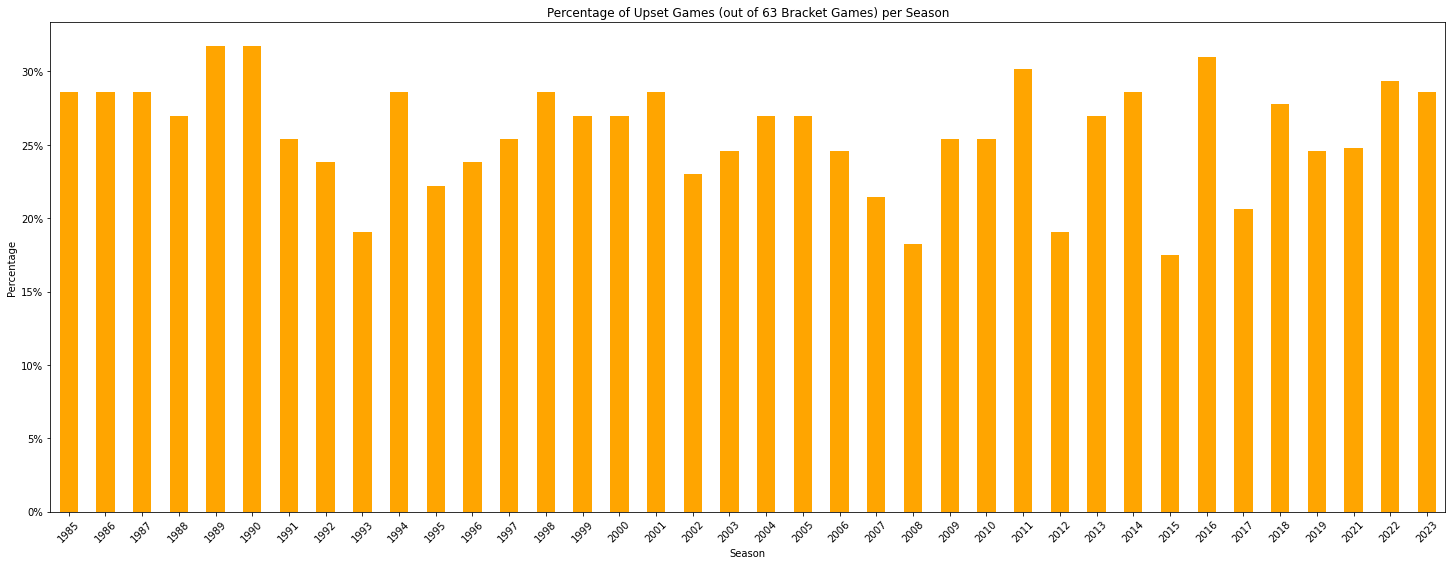

In [286]:
# plot percentage of upset games per season
upset_percentage = upsets.groupby('Season').count() / df_copy.groupby('Season').count()
upset_percentage['score_diff'].plot(kind='bar', figsize=(25, 9), title='Percentage of Upset Games (out of 63 Bracket Games) per Season', ylabel='Percentage', xlabel='Season' \
                                    , color='orange', rot=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

### Men's Upsets

In [262]:
# split on gender
mupsets = upsets.loc[upsets['A_TeamID'] < 3000]
wupsets = upsets.loc[upsets['A_TeamID'] >= 3000]

<ipython-input-287-ee34fb265e93>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


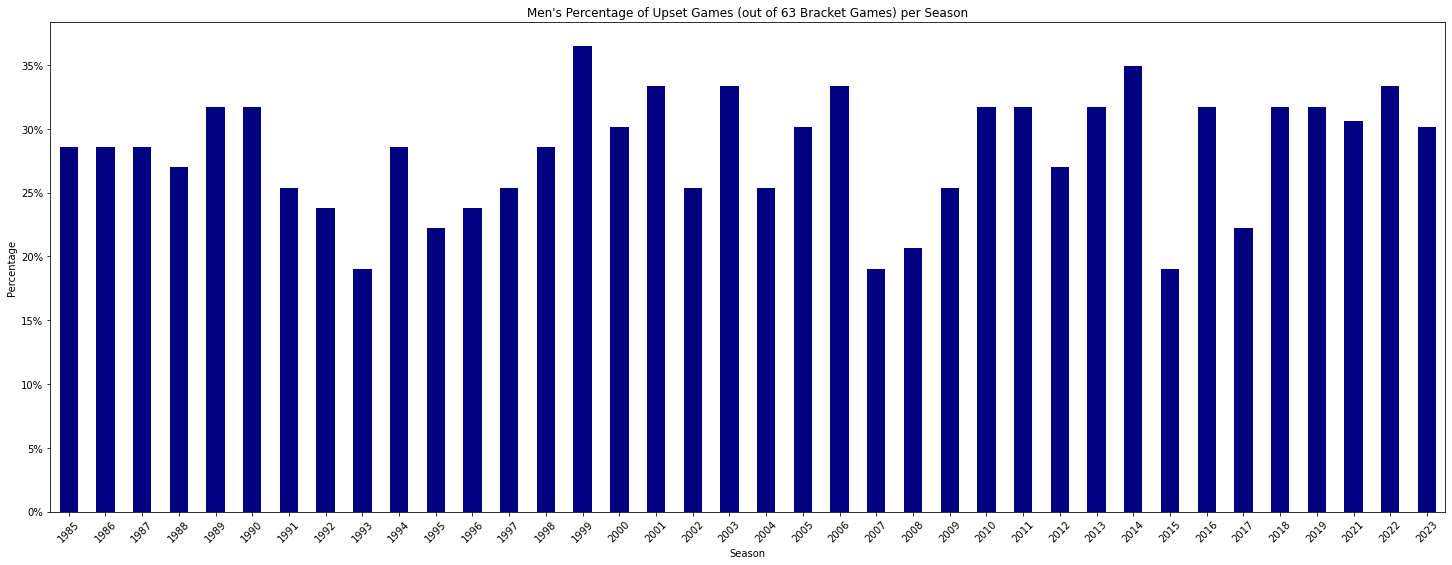

In [287]:
# plot men's percentage of upsets per season
mupset_percentage = mupsets.groupby('Season').count() / df_copy.loc[df_copy['A_TeamID'] < 3000].groupby('Season').count()
mupset_percentage['score_diff'].plot(kind='bar', figsize=(25, 9), title='Men\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', ylabel='Percentage', xlabel='Season' \
                                     , color='navy', rot=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

In [292]:
mupset_percentage.reset_index()

,A_Loc,A_PlayIn,A_Region,A_Seed,A_TeamID,A_avg_loss_diff,A_avg_win_diff,A_max_loss_diff,A_max_win_diff,A_min_loss_diff,A_min_win_diff,A_num_losses,A_num_wins,A_std_loss_diff,A_std_win_diff,A_win_ratio,B_PlayIn,B_Region,B_Seed,B_TeamID,B_avg_loss_diff,B_avg_win_diff,B_max_loss_diff,B_max_win_diff,B_min_loss_diff,B_min_win_diff,B_num_losses,B_num_wins,B_std_loss_diff,B_std_win_diff,B_win_ratio,NumOT,Seed_diff,avg_loss_diff_diff,avg_win_diff_diff,num_losses_diff,num_wins_diff,score_diff,std_loss_diff_diff,std_win_diff_diff,win,win_ratio_diff
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1985,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,0.269841,0.269841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.269841,0.269841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.269841,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,0.317460,0.317460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317460,0.317460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317460,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,0.317460,0.317460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317460,0.317460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317460,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,0.253968,0.253968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253968,0.253968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253968,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,0.238095,0.238095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238095,0.238095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238095,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,0.190476,0.190476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190476,0.190476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190476,NaN,NaN,NaN,NaN


### Women's Upsets

<ipython-input-288-04ebd4a30a5b>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


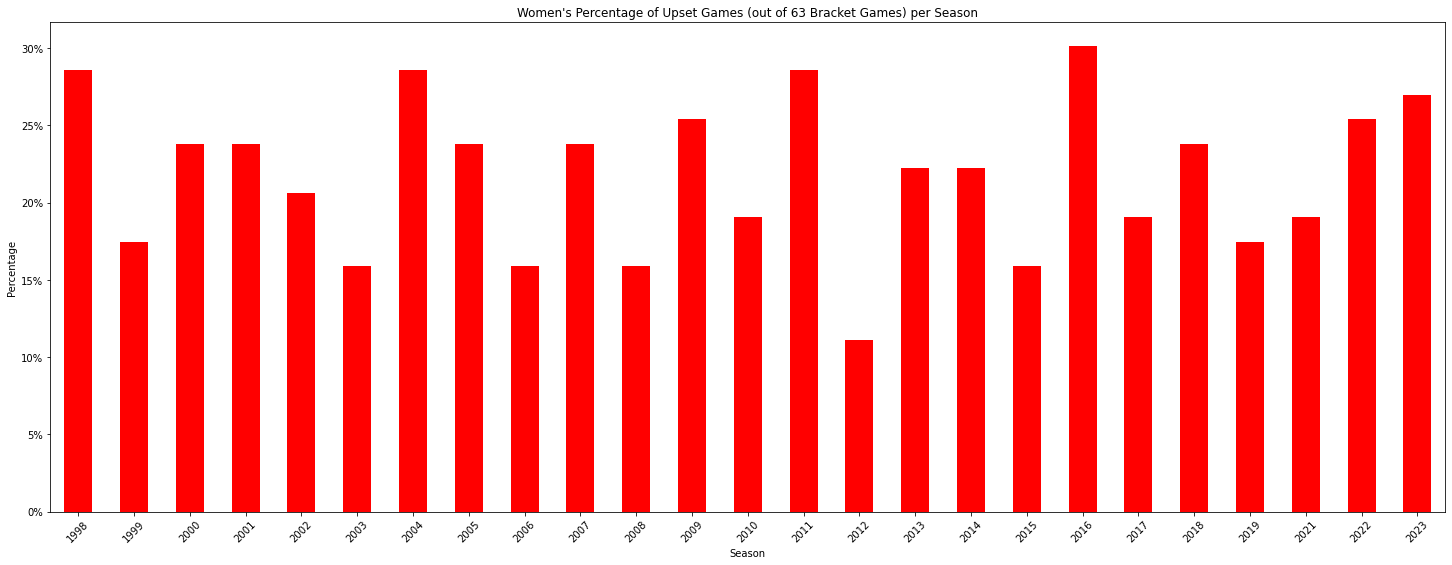

In [288]:
# plot women's percentage of upsets per season
wupset_percentage = wupsets.groupby('Season').count() / df_copy.loc[df_copy['A_TeamID'] >= 3000].groupby('Season').count()
wupset_percentage['score_diff'].plot(kind='bar', figsize=(25, 9), title='Women\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', ylabel='Percentage', xlabel='Season' \
                                     , color='red', rot=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

## Additional Data

In [60]:
# load data
ordinals = pd.read_csv(root + 'MMasseyOrdinals.csv')
coaches = pd.read_csv(root + 'MTeamCoaches.csv')

rounds = pd.read_csv(root + 'MNCAATourneySeedRoundSlots.csv')
conf_games = pd.read_csv(root + 'MConferenceTourneyGames.csv')
sec_teams = pd.read_csv(root + 'MSecondaryTourneyTeams.csv')
sec_results = pd.read_csv(root + 'MSecondaryTourneyCompactResults.csv')

#### Secondary Tournaments:
Tournaments played after Selection Sunday (Day 132). Not included in reg season CSVs.